In [1]:
%matplotlib inline
from __future__ import division

import numpy as np
import pandas as pd
import json
import csv
import collections
import re

import matplotlib.pyplot as plt
import seaborn as sns

import pysentiment as ps

# SK-learn libraries for learning.
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

from scipy.stats import uniform

import pydot

Load the train and test data set into a pandas dataframe

In [2]:
train = pd.read_json('train.json', convert_dates=['unix_timestamp_of_request'])
test = pd.read_json('test.json', convert_dates=['unix_timestamp_of_request'])

There are more columns in the train dataset than there are in the test dataset. This function removes those features because we cannot use them in the model

In [3]:
def remove_train_features():
    data_cols = set(train.columns.values)
    test_cols = set(test.columns.values)
    trim_data_cols = data_cols.intersection(test_cols)
    return list(trim_data_cols)

trim_data_cols = remove_train_features()
trim_data_cols.append('requester_received_pizza') 
train = train[trim_data_cols]

Below are keywords from topics described by the accompanying paper: http://cs.stanford.edu/~althoff/raop-dataset/altruistic_requests_icwsm.pdf. The following function looks in each post, both the title and the text to see if any of the words from the topic are included in the post. Through error analysis, we noticed our models misclassified military posts, so we added a category for that in addition to the categories in the paper

In [4]:
# Topics and keywords from paper
job = ['work', 'paycheck', 'unemployment', 'interview', 'fired', 'unemployment', 'hire', 'hired']
money = ['money', 'now', 'broke', 'week', 'until', 'time', 'last', 'day', 'when', 'today', 'tonight', 'paid', 'next', 'first', 'night', 'after', 'tomorrow', 'month', 'while', 'account', 'before', 'long', 'friday', 'rent', 'buy', 'bank', 'still', 'bills', 'ago', 'cash', 'due', 'past', 'never', 'paycheck', 'check', 'spent', 'years', 'poor', 'till', 'yesterday', 'morning', 'dollars', 'financial', 'hour', 'bill', 'evening', 'credit', 'budget', 'loan', 'bucks', 'deposit', 'dollar', 'current', 'payed']
student = ['college', 'student', 'school', 'roommate', 'studying', 'semester', 'university', 'finals', 'study', 'class', 'project', 'dorm', 'tuition']
family = ['family', 'mom', 'wife', 'wifey', 'parents', 'mother', 'husband', 'dad', 'son', 'daughter', 'father', 'parent', 'mom', 'baby', 'born', 'newborn', 'kid', 'children', 'child']
craving = ['friend', 'girlfriend', 'craving', 'birthday', 'boyfriend', 'celebrate', 'party', 'game', 'games', 'movie', 'date', 'drunk', 'beer', 'celebrating', 'invited', 'drinks', 'crave', 'wasted', 'invite']
gratitude = ['thank', 'thanks', 'blessed', 'bless', 'grateful']
military = ['veteran', 'army', 'navy', 'force', 'vet', 'seals', 'marine', 'va', 'veterans']

In [5]:
def get_word_counts(df, word_list):
    entry_count = []
    for entry in df.all_text:
        word_dict = dict((x,0) for x in word_list)
        for word in re.findall(r"\w+", entry):
            if word in word_dict:
                word_dict[word] += 1
        entry_count.append(sum(word_dict.values()))
    return pd.Series(entry_count)

Next, we used sklearn's CountVectorizer to create a bag of words for both successful posts (meaning they received a pizza) and unsuccessful posts. After removing stop words, we look for the top 50 words that appear in successful posts, but not unsuccessful posts. We then remove any words that show up in any of the categories previously defined. We do this because when looking at a correlation plot, many of the categories are closely correlated with postive terms. By removing overlapping terms, we can add more descriptive features. We also removed varies words associated with images, as images are more prevalent in successful posts. 

In [6]:
def get_pos_train_text(orig_df, top_k=10):
    df = orig_df.copy()
    df['all_text'] = [df.request_title.iloc[[i]].tolist()[0] + ' ' + df.request_text_edit_aware.iloc[[i]].tolist()[0]
                    for i in range(df.shape[0])]
    pos_post_text = [df.all_text[i] for i in range(df.shape[1]) if df.requester_received_pizza[i] == 1]
    neg_post_text = [df.all_text[i] for i in range(df.shape[1]) if df.requester_received_pizza[i] == 0]
    cv = CountVectorizer(stop_words='english', max_features=top_k)
    cv.fit_transform(pos_post_text)
    pos_words = collections.OrderedDict(sorted(cv.vocabulary_.items()))
    
    cv_neg = CountVectorizer(stop_words='english', max_features=top_k)
    cv_neg.fit_transform(neg_post_text)
    neg_words = collections.OrderedDict(sorted(cv_neg.vocabulary_.items()))
    
    pos_words = set(pos_words.keys())
    neg_words = set(neg_words.keys())

    neg_dict = [i for i in neg_words if i not in pos_words]
    pos_dict = [i for i in pos_words if i not in neg_words]
    
    categories = job + money + family + student + craving + gratitude +military + ['http', 'jpg', 'imgur', 'com']

    p_output = [i for i in pos_dict if i not in set(categories)]
    
    return p_output

pos_words = get_pos_train_text(train, 40)
print pos_words

[u've', u'pie', u'weather', u'odd', u'thought', u'working', u'pay', u'able', u'noms', u'payday', u'willing', u'forward', u'sort', u'offer', u'virginia', u'pasta', u'worked', u'weekend', u'om', u'did', u'requesting', u'receive', u'cheer', u'roommates', u'woke', u'feeling']


The reciprocity function searches for phrases that imply the requester will contribute a pizza to someone else in the future

In [7]:
# actual search for reciprocity - seems to be coming up on error analysis
def reciprocity_search(df):
    reciprocate = []
    all_text = df.all_text.values
    comps = [re.compile(r'return.+favor'), re.compile(r'pay.+forward'), re.compile(r'pay.+back'),
             re.compile(r'give.+back'), re.compile(r'repay'), re.compile(r'reciprocate'), re.compile(r'participate')]

    for entry in range(len(all_text)):
        contains_words = 0
        for comp in comps:
            if len(re.findall(comp, all_text[entry].lower())) > 0:
                contains_words = 1
        reciprocate.append(contains_words)
    return reciprocate

Below are preprocessing functions. Each step appends a new feature to the dataframe. We do this so no data are lost during feature engineering. Dummy variables are created for categorical variables such as days of the week and months

In [8]:
# Feature creation
def encode_features(df, fte):
    '''create dummy variables for categorical data'''
    for feature in fte:
        df = df.join(pd.get_dummies(df[feature], prefix=feature))
    return df

def preprocess(df):
    df['karma_cat_2'] = np.where(df.requester_upvotes_minus_downvotes_at_request <= 10, 0, 1)
    df['all_text'] = [df.request_title.iloc[[i]].tolist()[0] + ' ' + df.request_text_edit_aware.iloc[[i]].tolist()[0]
                    for i in range(df.shape[0])]
    
    # add categories
    df['job_c'] = get_word_counts(df, job)
    df['money_c'] = get_word_counts(df, money)
    df['student_c'] = get_word_counts(df, student)
    df['family_c'] = get_word_counts(df, family)
    df['craving_c'] = get_word_counts(df, craving)
    df['gratitude_c'] = get_word_counts(df, gratitude)
    df['military_c'] = get_word_counts(df, military)
    
    # mapping new variables
    df['post_length'] = df['request_text_edit_aware'].map(lambda x: len(x))
    df['request_title_length'] = df['request_title'].map(lambda x: len(x))
    df['pos_words'] = get_word_counts(df, pos_words)
    df['link'] = map(lambda x: 1 if x.find('http') > 0 else 0, df['request_text_edit_aware'])
    df['img'] = map(lambda x: 1 if x.find('img') > 0 else 0, df['request_text_edit_aware'])
    df['weekday'] = map(lambda x: x.weekday(), df['unix_timestamp_of_request'])
    df['month'] = map(lambda x: x.month, df['unix_timestamp_of_request'])
    df['hour'] = map(lambda x: x.hour, df['unix_timestamp_of_request'])
    df['dayct'] = map(lambda x: x.day, df['unix_timestamp_of_request'])
    
    # call the reciprocate function
    reciprocate = reciprocity_search(df)
    df['reciprocate_c'] = reciprocate
    
    # binary variables
    df['newacct'] = map(lambda x: 1 if x > 0 else 0, df['requester_account_age_in_days_at_request'])
    df['military_bin'] = map(lambda x: 1 if x > 0 else 0, df['military_c'])
    df['gratitude_bin'] = map(lambda x: 1 if x > 0 else 0, df['gratitude_c'])
    df['pos_words_bin'] = map(lambda x: 1 if x > 0 else 0, df['pos_words'])
    df['posted_before_bin'] = map(lambda x: 1 if x > 0 else 0, df['requester_number_of_posts_on_raop_at_request'])
    df['afternoon'] = map(lambda x: 1 if (x >= 13 and x <= 19) else 0, df['hour'])
    df['evening'] = map(lambda x: 1 if (x >= 19 and x <= 23) else 0, df['hour'])
    df['firsthalf'] = map(lambda x: 1 if (x <= 15 ) else 0, df['dayct'])
    df['link_or_img'] = map(lambda x: 1 if x.find('img') > 0 or x.find('http') > 0 else 0, df['request_text_edit_aware'])
    
    # median timestamp binary variable. Later posts seem to be less successful
    df['time_c'] = map(lambda x: 1 if x >= 1342561000 else 0, df['unix_timestamp_of_request_utc'])

    features_to_encode = ['weekday', 'hour', 'month']
    encode_features(df, features_to_encode) 
    
    return df

In [9]:
train_preprocess = preprocess(train)
test_preprocess = preprocess(test)

The following function returns a crosstable of a target variable and the outcome variable. It also shows a graph of percentage of successful posts for each category. This is useful to run over binary variables to see if there is actually a difference between each category. We used this to aid in feature selection.

requester_received_pizza  False  True 
time_c                                
0                          1444    576
1                          1602    418


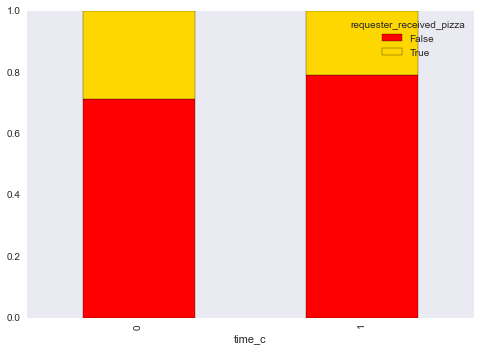

In [10]:
def get_dist(cat, labels):
    '''graphs crosstable for different variables with graph by % outcome'''
    crosstab = pd.crosstab(cat, labels)
    print(crosstab)
    crosstab.div(crosstab.sum(1).astype('float'), axis=0).plot(kind='bar', stacked=True, color=['red','gold'], grid=False)
    
get_dist(train_preprocess.time_c, train_preprocess.requester_received_pizza)

requester_received_pizza  False  True 
newacct                               
0                           760    141
1                          2286    853


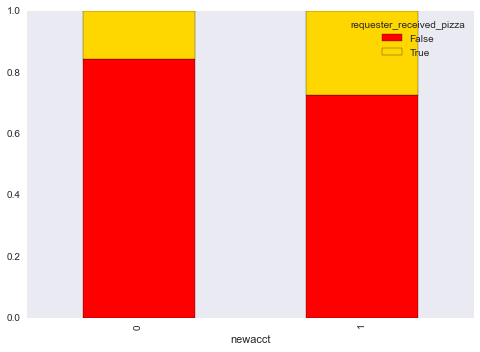

In [11]:
get_dist(train_preprocess.newacct, train_preprocess.requester_received_pizza)

requester_received_pizza  False  True 
karma_cat_2                           
0                          1007    208
1                          2039    786


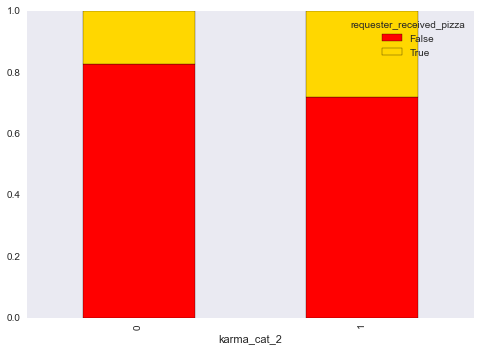

In [12]:
get_dist(train_preprocess.karma_cat_2, train_preprocess.requester_received_pizza)

After exploring the features (many graphs not included here), we chose the features to include in our model. We pulled out the features from the dataframe and normalized the values using sklearn's StandardScalar(). We then shuffled the data to ensure ordering did not affect the test/dev split. Then used 80% of the data for training and 20% for validating.

In [13]:
features = ['karma_cat_2', 'afternoon', 'img', 'gratitude_c','requester_number_of_posts_on_raop_at_request',
            'money_c', 'family_c', 'craving_c','requester_number_of_comments_in_raop_at_request', 'time_c',
            'newacct', 'firsthalf', 'reciprocate_c', 'pos_words'
           ]

train_pre = preprocess(train)
test_pre = preprocess(test)

train_pre = train_pre[features]
test_pre = test_pre[features]

scaler = scalar = preprocessing.StandardScaler()
scaler.fit(train_pre.values)

train_sc = scalar.transform(train_pre.values)

np.random.seed(0)
shuffle = np.random.permutation(np.arange(train.shape[0]))

# Pull out text features
train_length = 3230
data_mat, labels = train_sc[shuffle], train.requester_received_pizza.values[shuffle]

# shuffle training data for error analysis
data_shuffle = pd.DataFrame(train, index=shuffle)

train_data, train_labels = data_mat[:train_length], labels[:train_length]
dev_data, dev_labels = data_mat[train_length:], labels[train_length:]

test_data = scalar.transform(test_pre.values)

/Users/mattmorgan/Dropbox/Berkeley/207DataSci/Pizza/testvenv/lib/python2.7/site-packages/sklearn/utils/validation.py:493: UserWarning: StandardScaler assumes floating point values as input, got int64
  "got %s" % (estimator, X.dtype))


Below is a correlation heatmap. We also used this during feature selection to remove overlapping variables or variables that do not seem to correlate with any of the other features. As you can see, 'firsthalf', the variable representing if the post was made in the first half of the month is not strongly correlated with any of the other features; it only adds minimal improvement to the model. Some other interesting things stand out, such as requester_number_of_comments_on_raop_at_request is correlates with karma and number of posts in the subreddit. Generally on Reddit, you get more karma when you comment and respond to your posts.

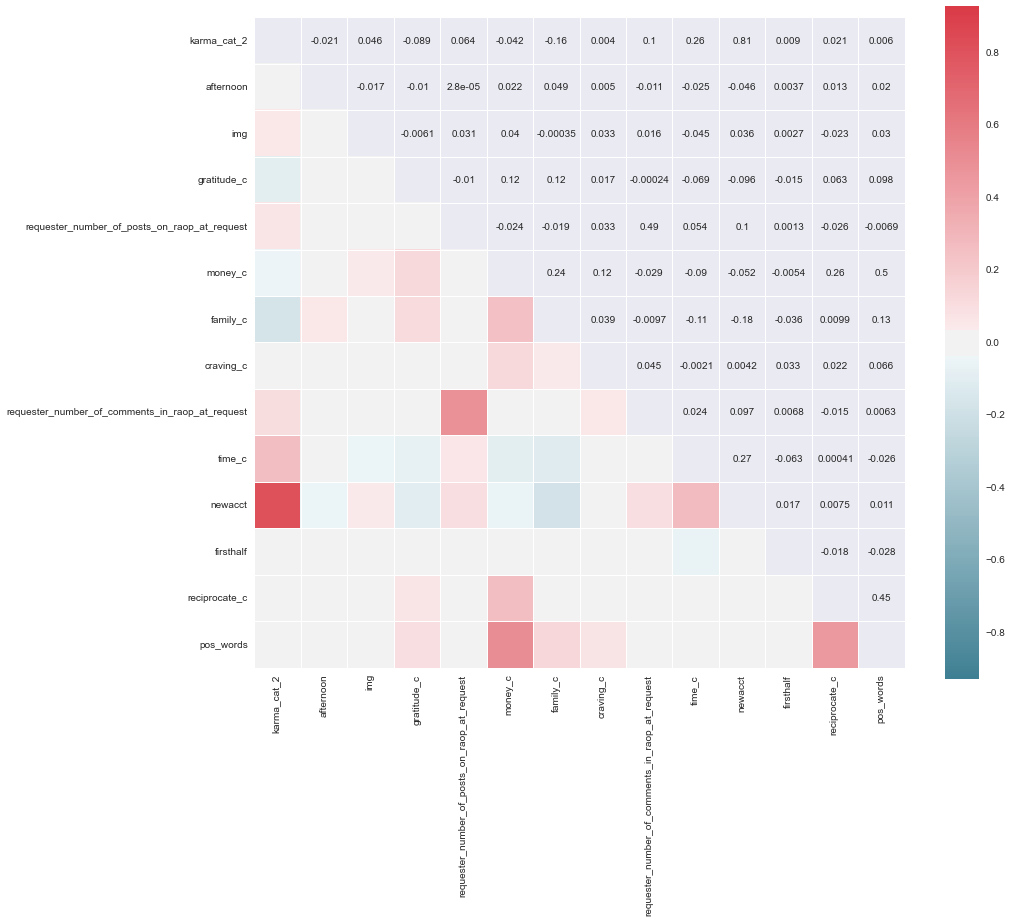

In [14]:
# Correlation heatmap all features 
def correlation_heatmap():
    fig, ax = plt.subplots(figsize=(15, 15), dpi=80)
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.corrplot(train_data, names=features, annot=True, sig_stars=False,
                 diag_names=False, cmap=cmap, ax=ax)
    fig.tight_layout()
    

correlation_heatmap()

We tried many different classifiers; however, AdaBoost consistently performed better than others. Many of our models, including Naive Bayes and K Nearest Neighbors failed to produce any positive predictions. Adaboost is an adaptive model that runs many iterations and re-weights training examples based on prior misclassifications. We used Decision Trees as the weak learner. After some tweaking, we setting on a max_depth of 1 and 290 estimators.

In [15]:
def ada_boost():
    
    clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=290)
    scores = cross_val_score(clf, train_data, train_labels)
    print scores
    clf.fit(train_data, train_labels)
    pred = clf.predict(dev_data)
    print clf.score(dev_data, dev_labels)
    print classification_report(pred, dev_labels)
    print clf.feature_importances_ 

    cm = confusion_matrix(dev_labels, pred)
    print(cm)
    return clf

    
ada = ada_boost()

[ 0.74930362  0.77251625  0.75743494]
0.769135802469
             precision    recall  f1-score   support

      False       0.97      0.78      0.86       757
       True       0.17      0.64      0.27        53

avg / total       0.92      0.77      0.82       810

[ 0.0137931   0.00689655  0.00689655  0.01034483  0.01724138  0.34827586
  0.06551724  0.03448276  0.4         0.01034483  0.0137931   0.00689655
  0.00344828  0.06206897]
[[589  19]
 [168  34]]


We next ran a logistic regression. We used grid search to find the best parameters. Unsurprisingly, the model came out with L2 regularization and a C parameter of .2. This model did slightly worse than Adaboost and slightly better than guessing False every time. As part of feature selection, we looked at the coefficients for each feature. We pruned the features so that features that did not have an impact on the model were excluded. This also improved the performance of other models.

In [16]:
def log_reg():
    param_grid = [{'C': np.arange(.1, 1, .1), 'penalty': ['l1', 'l2']}]
    logreg = LogisticRegression()
    logreg = GridSearchCV(logreg, param_grid)
    logreg.fit(train_data, train_labels)
    print("Best C: {}, with and accuracy of: {}".format(logreg.best_params_, logreg.best_score_))
    pred = logreg.predict(dev_data)
    print logreg.score(dev_data, dev_labels)
    print classification_report(pred, dev_labels)
    print logreg.best_estimator_.coef_
    return logreg
    

logreg = log_reg()

Best C: {'penalty': 'l1', 'C': 0.20000000000000001}, with and accuracy of: 0.761300309598
0.76049382716
             precision    recall  f1-score   support

      False       0.98      0.77      0.86       780
       True       0.09      0.63      0.16        30

avg / total       0.95      0.76      0.83       810

[[ 0.15394642  0.15065717  0.10929623  0.06771528  0.24383823  0.22073975
   0.05636919 -0.09769272  0.21144176 -0.29125026  0.20862248  0.08077205
   0.05400395  0.17331487]]


Finally, we weighted each model. We got the best results when assigning any positive prediction as a success. Since both the AdaBoost and the LogisticRegression models had the same True recall rate, we can expect the recall rate to remain the same when assigning a postive to prediction if the results from either model were positive. If we only assign a positive prediction where both models predicted a positive result, the recall score goes up; however, the accuracy decreases. Since we are competing for the highest accuracy, that is the number we should maximize

In [17]:
def weighted_model(data):
    ada_pred = map(lambda x: 1. if x == True else 0., ada.predict(data))
    logreg_pred = map(lambda x: 1. if x == True else 0., logreg.best_estimator_.predict(data))

    final_preds = []
    for i in range(data.shape[0]):
        w = ada_pred[i] + logreg_pred[i]
        w_pred = 1.0 * w / 2
        if w_pred >= .5:
            final_preds.append(1)
        else:
            final_preds.append(0)
    
    return final_preds

def get_accuracy(final_preds):
    correct = 0
    total = 0
    for j in range(len(final_preds)):
        if final_preds[j] == dev_labels[j]:
            correct += 1
        total += 1
    print 1.0 * correct / total 

final_preds = weighted_model(dev_data)
print classification_report(final_preds, dev_labels)
get_accuracy(final_preds)

             precision    recall  f1-score   support

          0       0.96      0.78      0.86       748
          1       0.19      0.63      0.30        62

avg / total       0.90      0.77      0.82       810

0.77037037037


Next, we run the test data through the training models. Then we predict the output and save to a csv for uploading to Kaggle.

In [18]:
test_preds = weighted_model(test_data)
request_ids = test['request_id'].values

In [19]:
with open('submission.csv', 'wb') as csvfile:
    outputwriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
    outputwriter.writerow(['request_id'] + ['requester_received_pizza'])
    
    for i in range(len(request_ids)):
        outputwriter.writerow([request_ids[i], str(test_preds[i])])

Below is some error analysis. We looked at the top mistakes generated by model by looking at which predictions were the furthest off as shown by their predicted probability score. When evaluating these results after a few iterations, we went back and added features such as 'military' and 'words associated with postive results' and refined other variables such as 'reciprocity'

In [20]:
# Error analysis
def get_top_misses(preds, probas, n=3):
    max_misses = np.zeros(n)
    max_misses_idx = np.zeros(n)
    for i in range(len(preds)):
        if preds[i] != dev_labels[i]:
            prob = max(probas[i])
            if np.amin(max_misses) < prob:
                idx = np.argmin(max_misses)
                max_misses[idx] = prob
                max_misses_idx[idx] = i
    return max_misses_idx
    

def error_analysis():
    ada_pred = ada.predict(dev_data)
    ada_proba = ada.predict_proba(dev_data)
    logreg_pred = logreg.predict(dev_data)
    logreg_proba = logreg.best_estimator_.predict_proba(dev_data)
    ada_top_misses = get_top_misses(ada_pred, ada_proba, 5)

    for i in ada_top_misses:
        print "Correct Label: %s" % dev_labels[i]
        print data_shuffle.all_text.iloc[[i+train_length]].tolist()[0] 
        print ""
error_analysis()    
    

Correct Label: False
[Request] Papa Johns has buffalo sauce as a topping again! (OH, USA) This was my favorite short term promotion and its back! I don't have the money otherwise I would buy it myself. Thanks for reading my post and have an awesome day!

Correct Label: False
[REQUEST] Mckees Rocks, Pa Could really go for a pizza I lost my job a few weeks ago and also just ended a very bad engagement. I am a single mom with 3 kids and we really would like pizza but I have no money until my unemployment starts. If anyone could help us out it would be great.

Correct Label: True
[request] Have had a run of bad luck in the last few days... Will return the favor next week... So I had an ex-roommate who owed me a portion of the deposit from our last place, and I stupidly gave him my bank info so he could wire the funds to me. Note: I used to have a wells fargo account so thats how we used to transfer funds easily for rent etc... but I moved and found it easier to use a schwab account since t

APPENDIX

We wanted to note we did try many other things; however, we were most interested to learn that sentiment analysis did not seem to influence the model.

In [21]:
def get_sentiment(df):
    hiv4 = ps.HIV4()
    df['sentiment_polarity'] = map(lambda x: hiv4.get_score(hiv4.tokenize(x))['Polarity'], df['all_text'])
    df['sentiment_positive'] = map(lambda x: hiv4.get_score(hiv4.tokenize(x))['Positive'], df['all_text'])
    df['sentiment_negative'] = map(lambda x: hiv4.get_score(hiv4.tokenize(x))['Negative'], df['all_text'])
    df['sentimented_words'] = df['sentiment_positive'] + df['sentiment_negative']
    df['sentiment_ratio'] = df['sentiment_positive']/df['sentimented_words'].replace({ 0 : np.nan })
    df['sentiment_ratio'] = df['sentiment_ratio'].replace({np.nan : 0})
    return df

In [22]:
def additional_preprocess(df):
    get_sentiment(df)
    df['sentiment_ratio_bin'] = map(lambda x: 1 if x > .5 else 0, df['sentiment_ratio'])
    df['sentiment_polarity_bin'] = map(lambda x: 1 if x > 0 else 0, df['sentiment_polarity'])
    return df
    
    
add_preprocess = additional_preprocess(train_preprocess)

/Users/mattmorgan/Dropbox/Berkeley/207DataSci/Pizza/testvenv/lib/python2.7/site-packages/pandas/io/parsers.py:1164: DtypeWarning: Columns (63,108,109,110,176) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


requester_received_pizza  False  True 
sentiment_ratio_bin                   
0                          1102    298
1                          1944    696


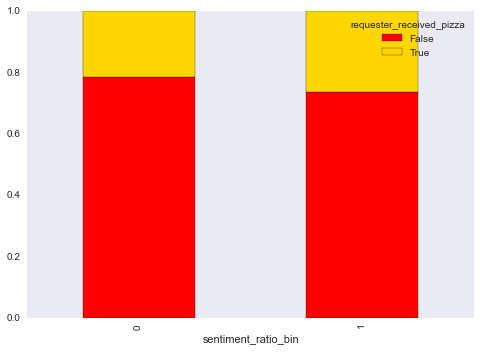

In [23]:
get_dist(add_preprocess.sentiment_ratio_bin, add_preprocess.requester_received_pizza)

requester_received_pizza  False  True 
sentiment_polarity_bin                
0                          1102    298
1                          1944    696


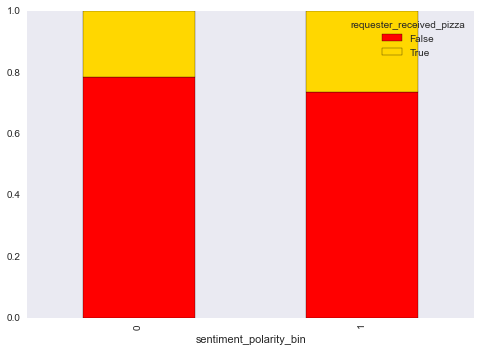

In [24]:
get_dist(add_preprocess.sentiment_polarity_bin, add_preprocess.requester_received_pizza)